In [64]:
ENV["PYTHONPATH"]="/home/gridsan/aligho/.local/lib/python3.8/site-packages/PyNormaliz-2.15-py3.8-linux-x86_64.egg";
using Crystalline, MPBUtils, SymmetryBases, JLD2, PyPlot, DelimitedFiles, PyCall, LinearAlgebra, Brillouin
shapely_point = pyimport("shapely.geometry").Point
shapely_polygon = pyimport("shapely.geometry.polygon").Polygon
cm = 1/2.54;
np = pyimport("numpy");

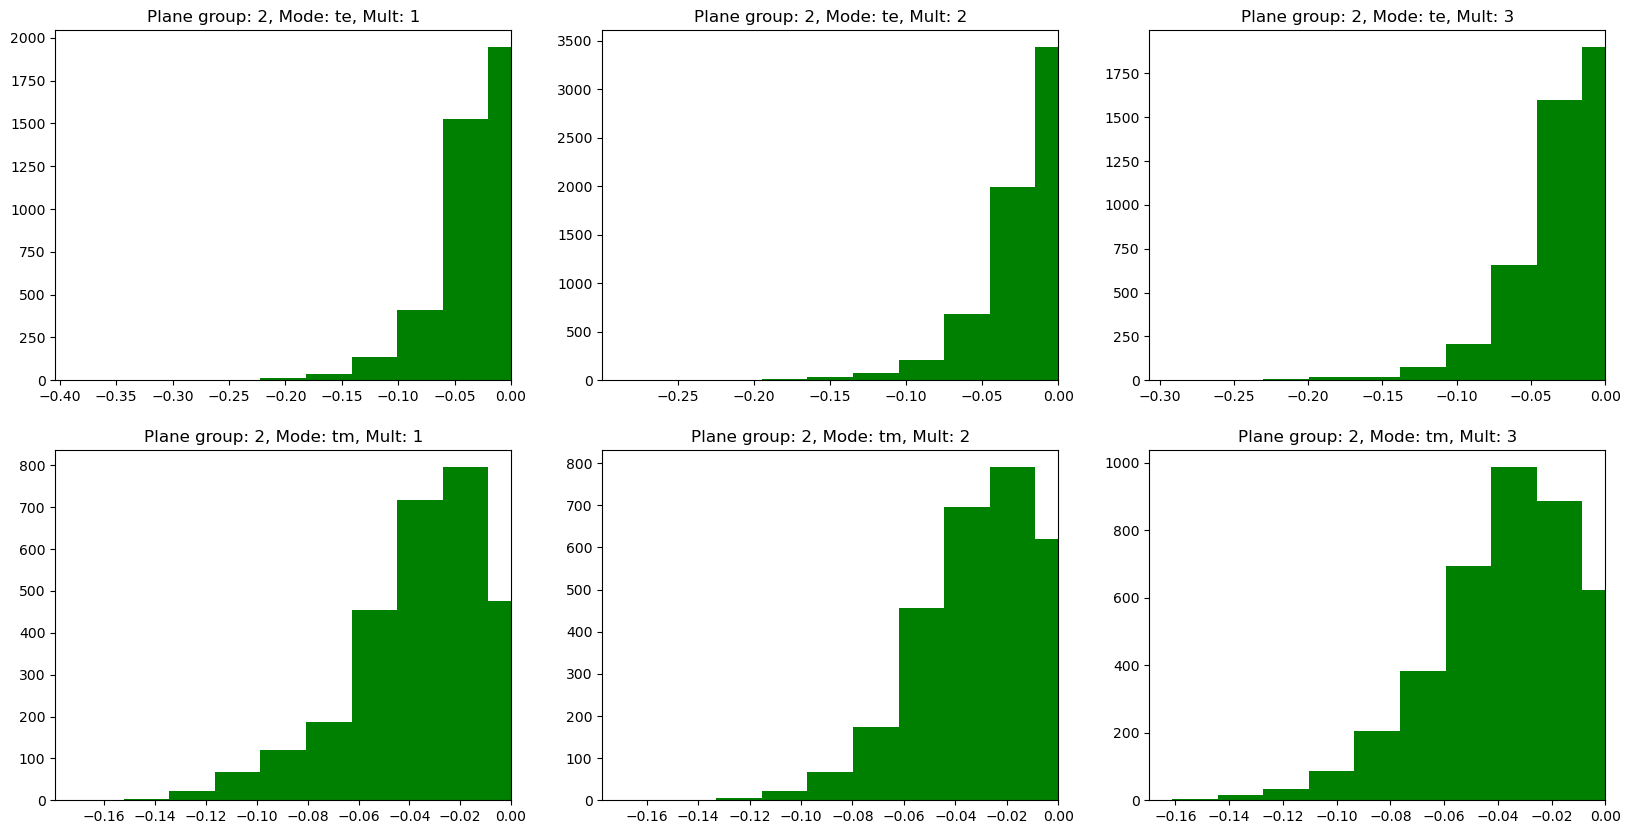

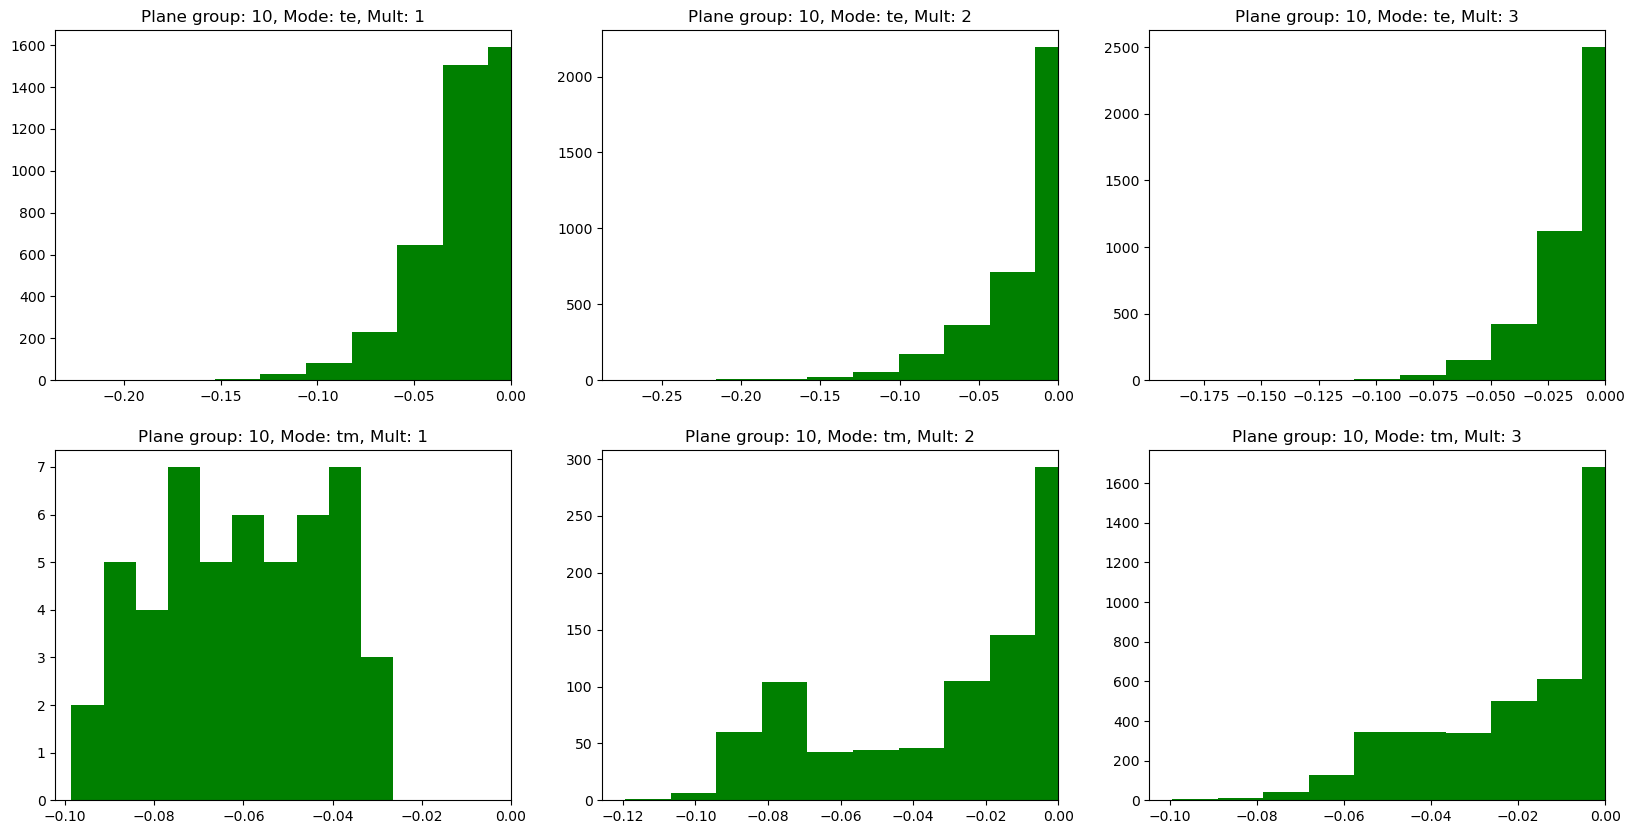

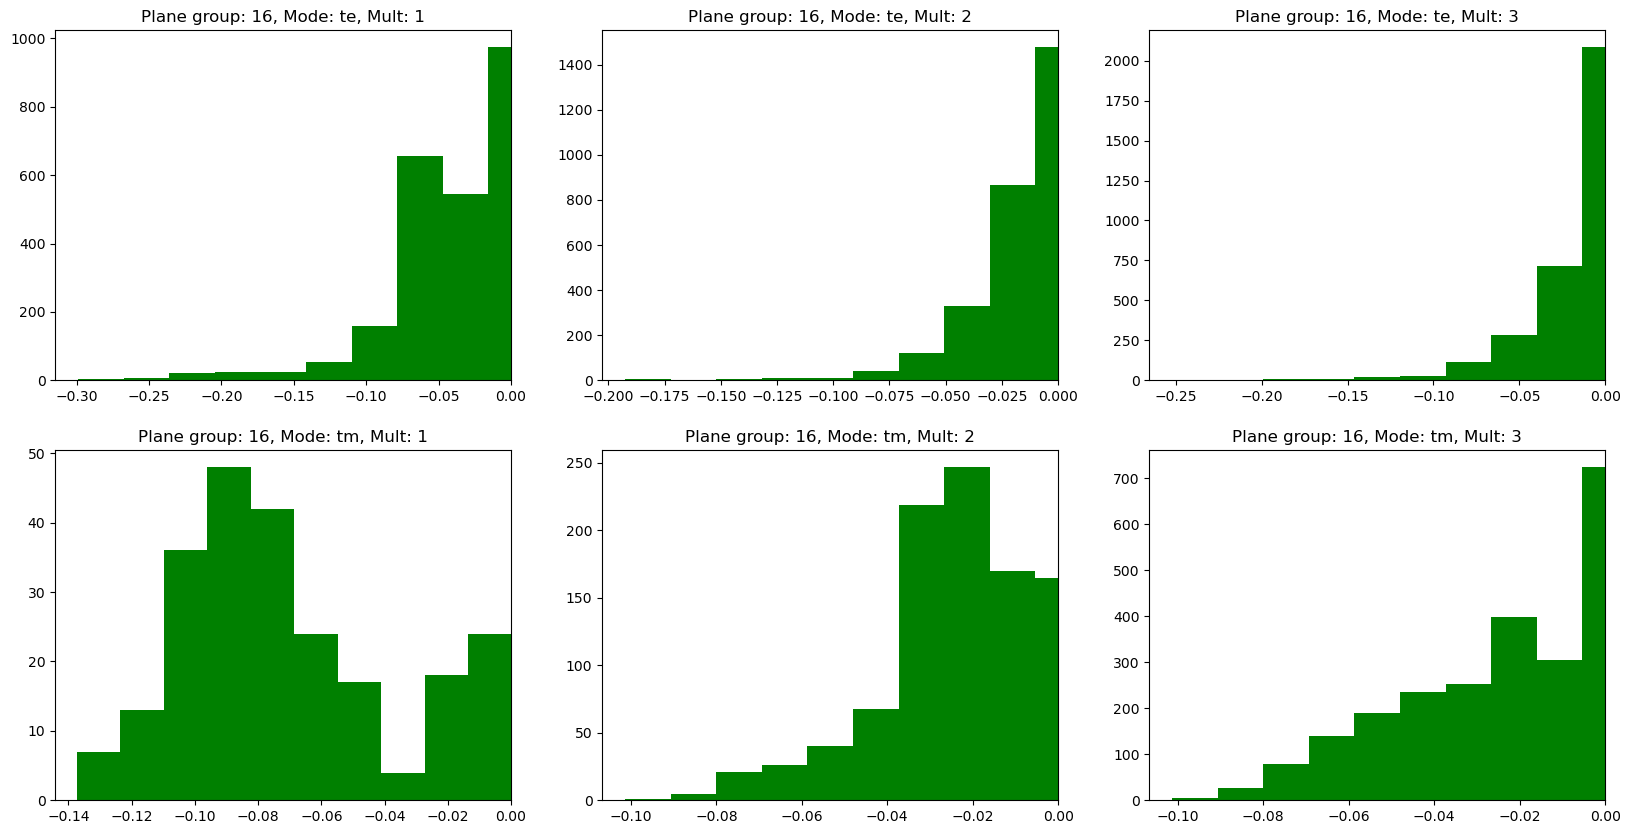

In [95]:
for sg in [2, 10, 16]
    loaded_data_tolerance = load("sg$(sg)_tolerance.jld2")["well_separated_nodal_points"];
    figure(figsize=(20, 10))
    for (i, mode) in enumerate(["te", "tm"])
        for mult in 1:3
            subplot(2, 3, mult + (i-1) * 3)
            vals = filter( x-> !isempty(x), [filter(x-> x[1] == mult, val) for (key, val) in filter(x->x[1][1] == mode, loaded_data_tolerance)]);
            vals = [val[1][3] for val in vals];
            x, y = np.histogram(vals)
            bar(y[2:end], x , width = first(diff(y)), color="green")
            xlim(minimum(y), 0)
            title("Plane group: $sg, Mode: $mode, Mult: $mult")
        end
    end
end

Plane group: 2
Plane group: 10
Plane group: 16


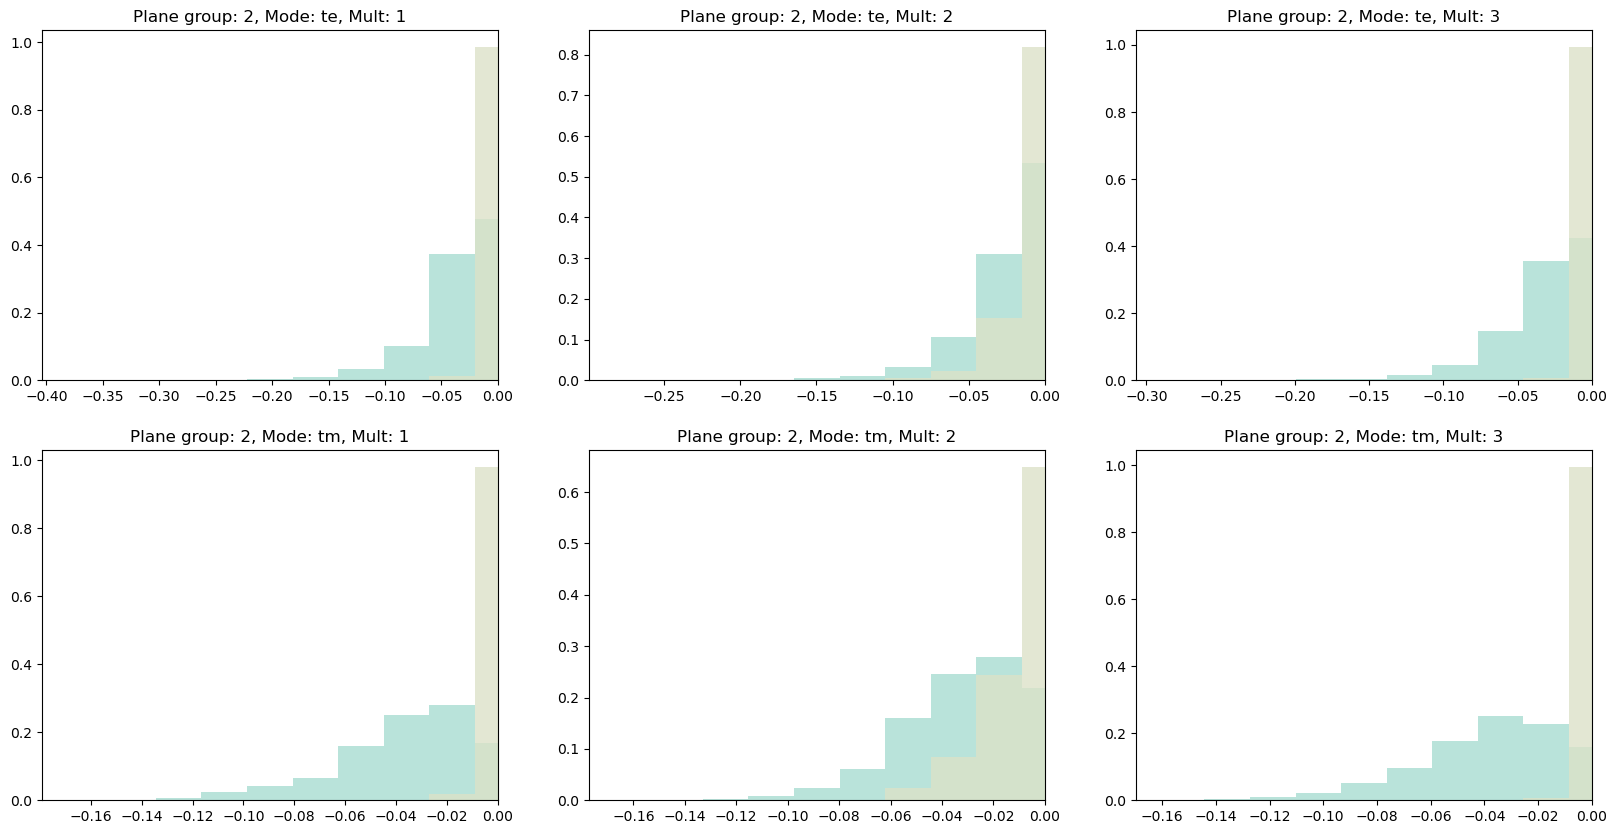

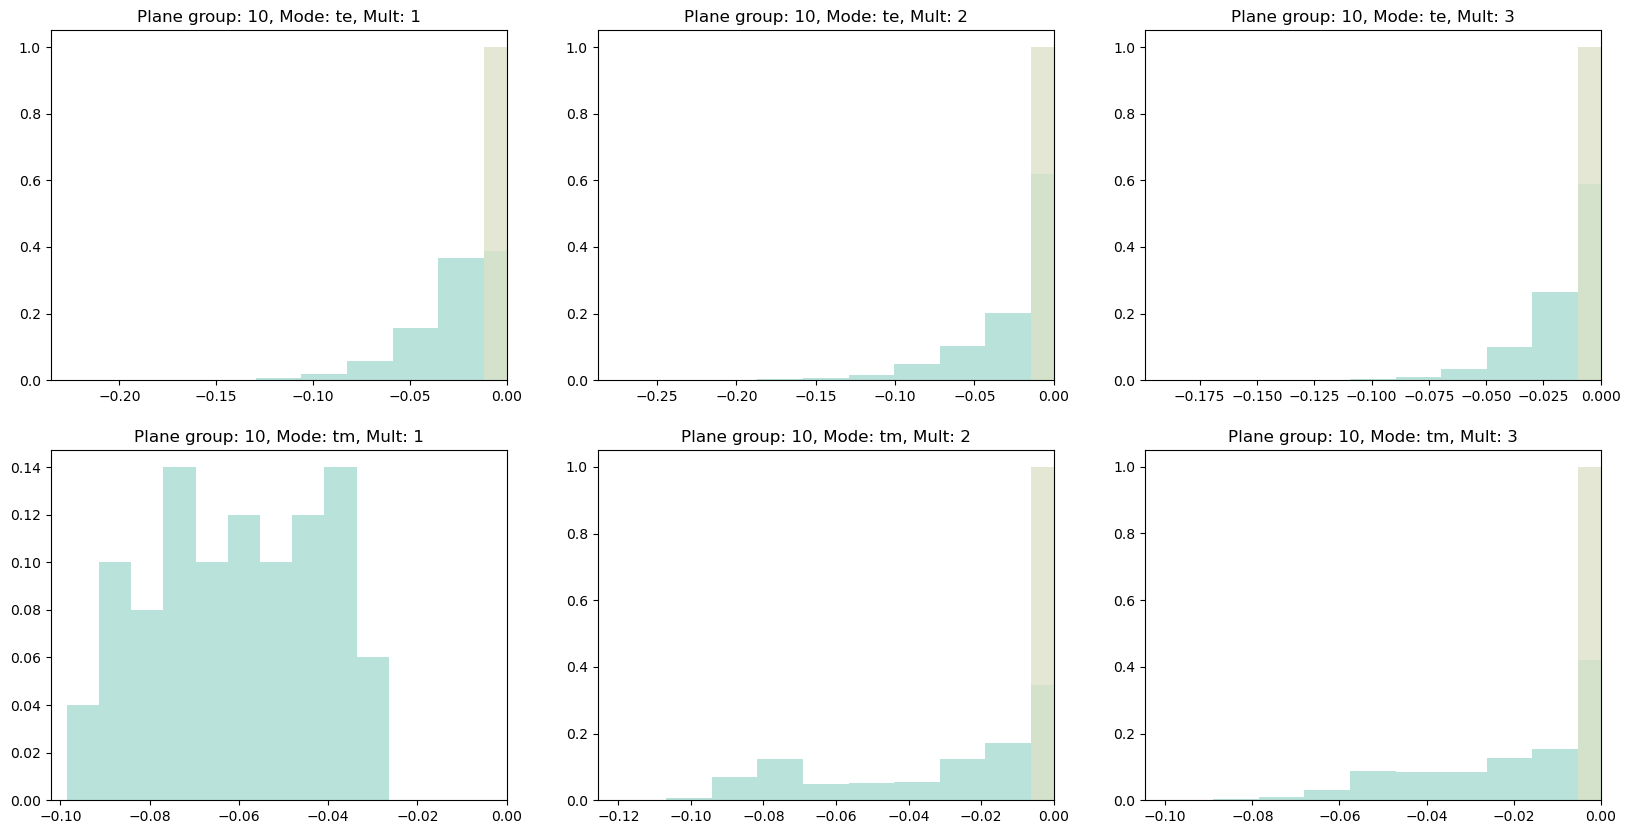

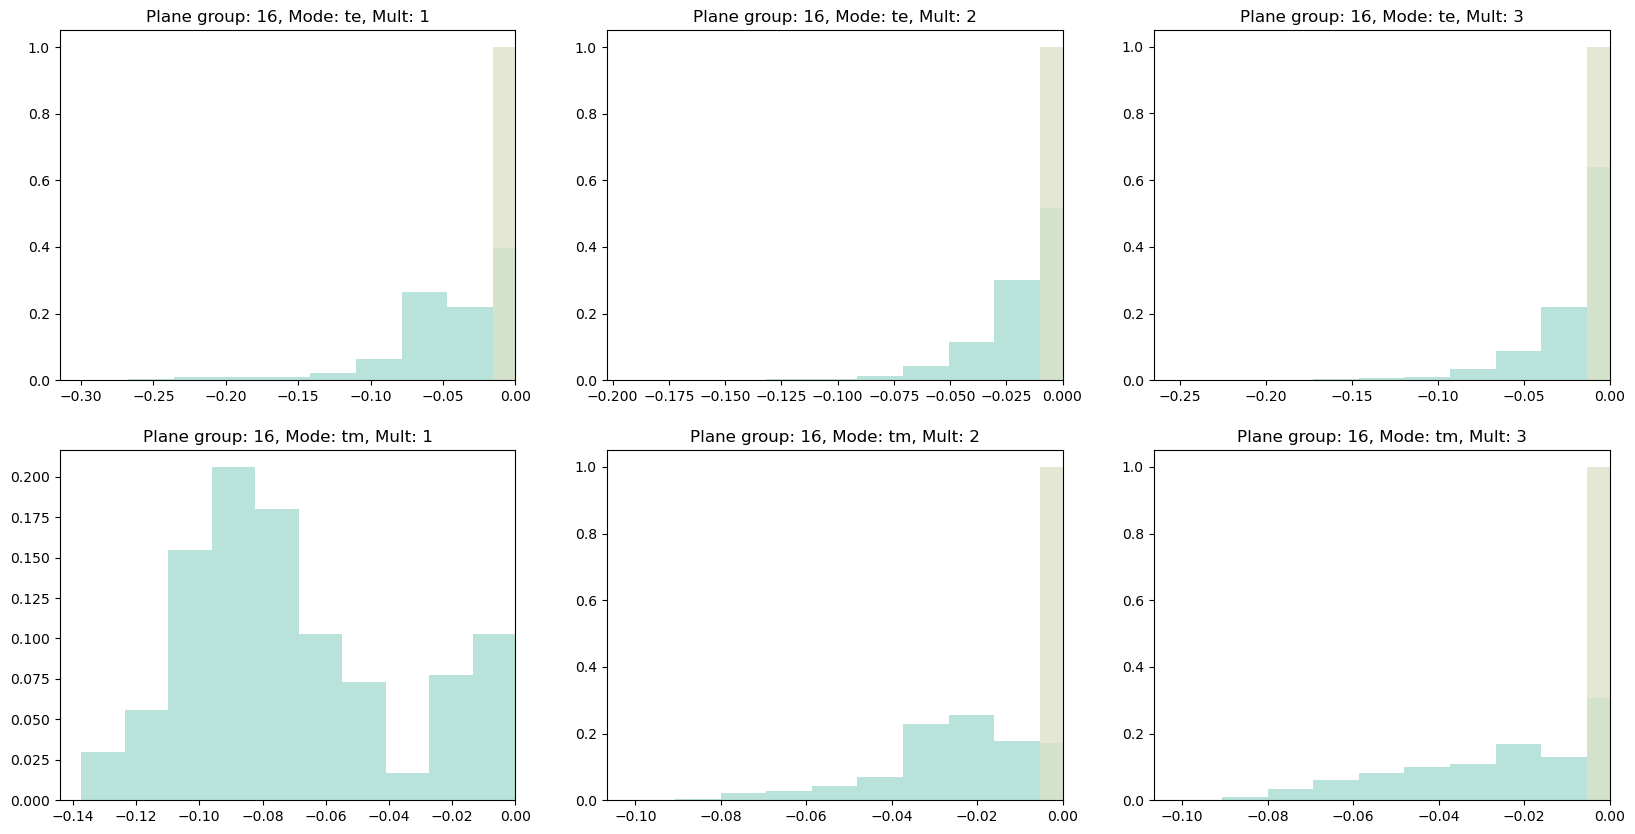

In [105]:
# Let's do the same as above but with a margin tolerance from the dispersion along "high-symmetry" lines
atol = 0
for sg in [2, 10, 16]
    println("Plane group: $(sg)"); flush(stdout)
    loaded_data_tolerance = load("sg$(sg)_tolerance.jld2")["well_separated_nodal_points"];
    dispersion_dir_te = "../dispersions/output/sg$sg/eps3/te/";
    dispersion_dir_tm = "../dispersions/output/sg$sg/eps3/tm/";
    loaded_dispersion_data_te = load(dispersion_dir_te*"sg$sg-epsid3-res64-te.jld2")
    loaded_dispersion_data_tm = load(dispersion_dir_tm*"sg$sg-epsid3-res64-tm.jld2");
    marginsv_te = loaded_dispersion_data_te["marginsv"]
    marginsv_tm = loaded_dispersion_data_tm["marginsv"];

    high_margin_data = Dict{Tuple{String, Integer}, Vector{Tuple{Integer, Integer, Float64, Float64}}}();
    for (key, val) in loaded_data_tolerance
        mode, real_idx = key
        idx = real_idx - 20000
        margins = (mode == "te" ? marginsv_te[idx] : marginsv_tm[idx])
        high_margin_band_infos = Vector{Tuple{Integer, Integer, Float64, Float64}}()
        for band_info in val
            mult = band_info[1]
            length(margins) >= mult || continue

            margin = margins[mult]
            how_separated = band_info[end - 1]
            (margin > atol) && push!(high_margin_band_infos, band_info)
        end
        !isempty(high_margin_band_infos) && push!(high_margin_data, key => high_margin_band_infos)
    end
    figure(figsize=(20, 10))
    for (i, mode) in enumerate(["te", "tm"])
        for mult in 1:3
            subplot(2, 3, mult + (i-1) * 3)
            vals_margin = filter(x-> !isempty(x), [filter(x-> x[1] == mult, val) for (key, val) in filter(x->x[1][1] == mode, high_margin_data)]);
            vals_margin = [val[1][3] for val in vals_margin];

            vals = filter( x-> !isempty(x), [filter(x-> x[1] == mult, val) for (key, val) in filter(x->x[1][1] == mode, loaded_data_tolerance)]);
            vals = [val[1][3] for val in vals];
            
            x, y = np.histogram(vals)
            x_margin, y_margin = np.histogram(vals_margin, y) # Make sure we have the same bins

            @assert y_margin == y
            bar(y[2:end], x / sum(x), width = first(diff(y)), color="#A8DCD1", alpha=0.8)
            bar(y_margin[2:end], x_margin / sum(x_margin), width = first(diff(y)), alpha = 0.8,color="#DCE2C8")

            xlim(minimum(y), 0)
            title("Plane group: $sg, Mode: $mode, Mult: $mult")
        end
    end
end

In [112]:
sg = 10
dispersion_dir_tm = "../dispersions/output/sg$sg/eps3/tm/";
loaded_dispersion_data_tm = load(dispersion_dir_tm*"sg$sg-epsid3-res64-tm.jld2");
marginsv_tm = loaded_dispersion_data_tm["marginsv"];
cumsummariesv_tm = loaded_dispersion_data_tm["cumsummariesv"];

In [118]:
idxs = findall(x -> x >=0, [x[1] for x in marginsv_tm]);
unique([x[1].topology for x in cumsummariesv_tm[idxs]])

1-element Vector{TopologyKind}:
 TRIVIAL::TopologyKind = 0